# Using Lime with Pytorch

In this tutorial we will show how to use Lime framework with Pytorch. Specifically, we will use Lime to explain the prediction generated by one of the pretrained ImageNet models.

Let's start with importing our dependencies. This code is tested with Pytorch 1.0 but should work with older versions as well.

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torch import nn

from lime import lime_image
from skimage.segmentation import mark_boundaries
import skimage

/home/rdaroya/miniconda3/envs/cs670-project/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
RANDOM_SEED = 0
MODEL_PATH = "/home/rdaroya/Documents/cs670-project/models/resnet50_oxford102_acc0.80.pth"
idx2label = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']
device = "cpu"
NUM_SAMPLES = 15    # number of samples to generate

np.random.seed(RANDOM_SEED)

In [4]:

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    trans = transforms.Compose([transforms.ToTensor(),normalize])


    return trans  


pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()



Load the pretrained model for Resnet50 available in Pytorch.

In [5]:
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

model = resnet50(weights=ResNet50_Weights.DEFAULT)
num_feats = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_feats, 1024),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(1024, 102),   # 102 Oxford102 Flower categories
)
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(device)

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
trans = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(), normalize])

testset = torchvision.datasets.Flowers102(
    root='./data', split='test', download=True, transform=trans)
test_dl = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=False#, num_workers=2
)


/home/rdaroya/miniconda3/envs/cs670-project/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU0 Tesla K40c which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
/home/rdaroya/miniconda3/envs/cs670-project/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GT 720 which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [6]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = "cpu"
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Get the predicition for a single image.

In [34]:
def get_reverse_rot_mask(rotated_mask, rot_val):

    unrot_mask_pos = (rotated_mask>0)
    unrot_mask_pos = skimage.transform.rotate(unrot_mask_pos, -rot_val, preserve_range=True, resize=False, clip=False, mode='constant', cval=0)
    unrot_mask_neg = (rotated_mask<0)
    unrot_mask_neg = skimage.transform.rotate(unrot_mask_neg, -rot_val, preserve_range=True, resize=False, clip=False, mode='constant', cval=0)

    unrot_mask = unrot_mask_pos.astype(int) + unrot_mask_neg.astype(int)*(-1)

    return unrot_mask

def compute_iou(mask, reversed_mask):
    pos_mask = (mask>0).astype(int)
    pos_reversed_mask = (reversed_mask>0).astype(int)
    union_pos = pos_mask + pos_reversed_mask

    neg_mask = (mask<0).astype(int)
    neg_reversed_mask = (reversed_mask<0).astype(int)
    union_neg = neg_mask + neg_reversed_mask

    pos_iou = np.sum(pos_mask&pos_reversed_mask)/(np.sum(union_pos>0) or 1e10)  # if sum is zero, make iou approach 0
    neg_iou = (np.sum(neg_mask&neg_reversed_mask)/(np.sum(union_neg>0) or 1e10))

    return pos_iou, neg_iou
    

In [35]:
pos_ious, neg_ious = [], []
for i, (inputs, targets) in enumerate(test_dl):
    rot_val = np.random.randint(low = 1, high=360) # generate random rotation values
    print(f"rot_val: {rot_val}")
    img = inputs.cpu().detach().numpy()
    img = img[0,:,:,:]
    img = img.swapaxes(0,1)
    img = img.swapaxes(1,2)
    img_np = img.copy()
    rotated_img = skimage.transform.rotate(
        img,
        rot_val,
        preserve_range=True,
        resize=False,
        clip=False,
        mode='constant',
        cval=0,
    )
    img = Image.fromarray(np.uint8((img-np.min(img))*255/(np.max(img)-np.min(img)))).convert('RGB')
    rotated_img = Image.fromarray(np.uint8((rotated_img-np.min(rotated_img))*255/(np.max(rotated_img)-np.min(rotated_img)))).convert('RGB')

    # predict on a single image
    test_pred = batch_predict([pill_transf(img)])
    pred_idx = test_pred.squeeze().argmax()
    pred_class = idx2label[pred_idx]
    target_class = idx2label[targets]

    print("Getting explanation for original image")
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        np.array(pill_transf(img)), 
        batch_predict, # classification function
        top_labels=5,
        hide_color=0,
        random_seed=RANDOM_SEED,
        num_samples=1000) # number of images that will be sent to classification function

    temp1, mask1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    img_boundry1 = mark_boundaries(temp1/255.0, mask1)

    # Shade areas that contribute to top prediction
    temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp2/255.0, mask2)


    # Explain rotated img
    print("Getting explanation for rotated image")
    rotated_explainer = lime_image.LimeImageExplainer()
    rotated_explanation = rotated_explainer.explain_instance(
        np.array(pill_transf(rotated_img)), 
        batch_predict, # classification function
        top_labels=5, 
        hide_color=0, 
        random_seed=RANDOM_SEED,
        num_samples=1000) # number of images that will be sent to classification function

    rotated_temp1, rotated_mask1 = rotated_explanation.get_image_and_mask(rotated_explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    rotated_img_boundry1 = mark_boundaries(rotated_temp1/255.0, rotated_mask1)

    # Shade areas that contribute to top prediction
    rotated_temp2, rotated_mask2 = rotated_explanation.get_image_and_mask(rotated_explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    rotated_img_boundry2 = mark_boundaries(rotated_temp2/255.0, rotated_mask2)

    # Compute iou between rotated images
    unrot_mask2 = get_reverse_rot_mask(rotated_mask2, rot_val)
    pos_iou, neg_iou = compute_iou(mask2, unrot_mask2)
    pos_ious.append(pos_iou)
    neg_ious.append(neg_iou)
    print(f"pos_iou: {pos_iou}, neg_iou: {neg_iou}")
    
    if i==16:
        break

rot_val: 189
Getting explanation for original image


100%|██████████| 1000/1000 [00:14<00:00, 70.24it/s]


Getting explanation for rotated image


100%|██████████| 1000/1000 [00:13<00:00, 74.85it/s]


pos_iou: 0.3454359297471844, neg_iou: 0.0011938516639307566
rot_val: 295
Getting explanation for original image


100%|██████████| 1000/1000 [00:13<00:00, 76.86it/s]


Getting explanation for rotated image


100%|██████████| 1000/1000 [00:12<00:00, 79.60it/s]


pos_iou: 0.46476392810219996, neg_iou: 0.0
rot_val: 50
Getting explanation for original image


100%|██████████| 1000/1000 [00:13<00:00, 74.20it/s]


Getting explanation for rotated image


100%|██████████| 1000/1000 [00:13<00:00, 73.61it/s]


pos_iou: 0.5922816901408451, neg_iou: 0.0
rot_val: 291
Getting explanation for original image


100%|██████████| 1000/1000 [00:13<00:00, 74.45it/s]


Getting explanation for rotated image


100%|██████████| 1000/1000 [00:13<00:00, 76.14it/s]
/tmp/ipykernel_238323/2740748121.py:22: RuntimeWarning: invalid value encountered in long_scalars
  neg_iou = np.sum(neg_mask&neg_reversed_mask)/np.sum(union_neg>0)


pos_iou: 0.31547436813280266, neg_iou: nan
rot_val: 352
Getting explanation for original image


100%|██████████| 1000/1000 [00:13<00:00, 73.41it/s]


Getting explanation for rotated image


100%|██████████| 1000/1000 [00:13<00:00, 74.82it/s]


pos_iou: 0.4130895169829763, neg_iou: 0.0
rot_val: 45
Getting explanation for original image


100%|██████████| 1000/1000 [00:14<00:00, 68.89it/s]


Getting explanation for rotated image


100%|██████████| 1000/1000 [00:14<00:00, 70.51it/s]


pos_iou: 0.7136722261060621, neg_iou: 0.0
rot_val: 13
Getting explanation for original image


100%|██████████| 1000/1000 [00:13<00:00, 73.44it/s]


Getting explanation for rotated image


100%|██████████| 1000/1000 [00:14<00:00, 68.57it/s]


pos_iou: 0.3652453355076982, neg_iou: 0.0
rot_val: 10
Getting explanation for original image


100%|██████████| 1000/1000 [00:14<00:00, 69.97it/s]


Getting explanation for rotated image


100%|██████████| 1000/1000 [00:14<00:00, 69.75it/s]
/tmp/ipykernel_238323/2740748121.py:22: RuntimeWarning: invalid value encountered in long_scalars
  neg_iou = np.sum(neg_mask&neg_reversed_mask)/np.sum(union_neg>0)


pos_iou: 0.10821760801769864, neg_iou: nan
rot_val: 149
Getting explanation for original image


100%|██████████| 1000/1000 [00:15<00:00, 65.53it/s]


Getting explanation for rotated image


100%|██████████| 1000/1000 [00:14<00:00, 67.64it/s]


pos_iou: 0.0979414523374636, neg_iou: 0.0
rot_val: 209
Getting explanation for original image


100%|██████████| 1000/1000 [00:15<00:00, 63.01it/s]


Getting explanation for rotated image


100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


pos_iou: 0.18837072631105886, neg_iou: 0.0
rot_val: 154
Getting explanation for original image


100%|██████████| 1000/1000 [00:15<00:00, 63.24it/s]


Getting explanation for rotated image


100%|██████████| 1000/1000 [00:15<00:00, 65.82it/s]


pos_iou: 0.2424895721047945, neg_iou: 0.0
rot_val: 263
Getting explanation for original image


 92%|█████████▏| 920/1000 [00:14<00:01, 57.15it/s]

In [33]:
unrot_mask_pos = (rotated_mask2>0)
unrot_mask_pos = skimage.transform.rotate(unrot_mask_pos, -rot_val, preserve_range=True, resize=False, clip=False, mode='constant', cval=0)
unrot_mask_pos.shape
    

(224, 224)

In [32]:
rotated_mask2.shape

(224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


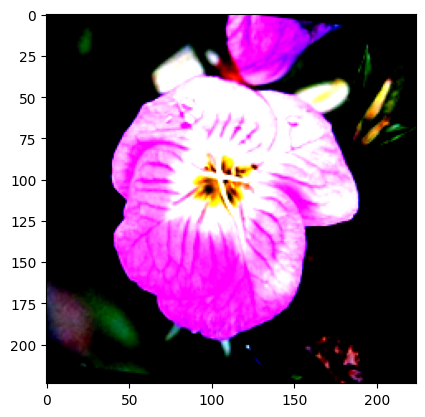

In [25]:
a = skimage.transform.rotate(img_np, 173)
print(a.shape)
plt.imshow(a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


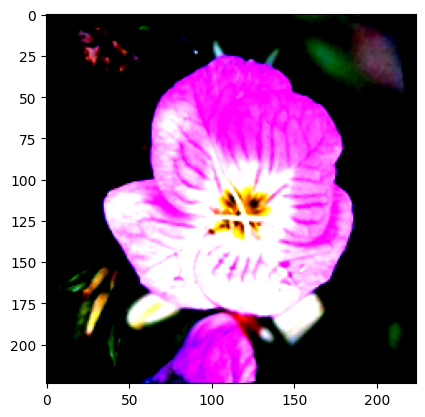

In [26]:
b = skimage.transform.rotate(a, -173)
print(b.shape)
plt.imshow(b)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


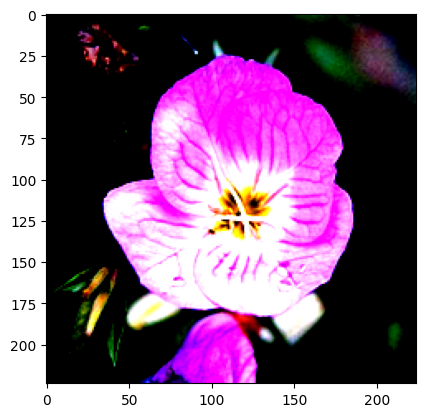

In [21]:
plt.imshow(img_np)

In [ ]:
sum(pos_ious)/len(pos_ious), sum(neg_ious)/len(neg_ious)

NameError: name 'pos_ious' is not defined

In [ ]:


pos_mask2 = (mask2>0).astype(int)
pos_unrot_mask2 = (unrot_mask2>0).astype(int)
union_pos = pos_mask2 + pos_unrot_mask2

neg_mask2 = (mask2<0).astype(int)
neg_unrot_mask2 = (unrot_mask2<0).astype(int)
union_neg = neg_mask2 + neg_unrot_mask2

pos_iou = np.sum(pos_mask2&pos_unrot_mask2)/np.sum(union_pos>0)
neg_iou = np.sum(neg_mask2&neg_unrot_mask2)/np.sum(union_neg>0)

pos_iou, neg_iou

(0.5455650553101827, 0.21748355612136644)

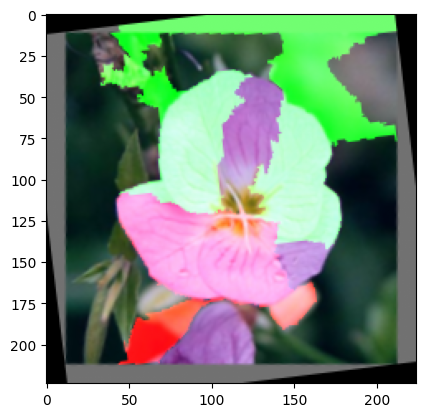

In [15]:
y = skimage.transform.rotate(rotated_temp2, -173)
# samp = mark_boundaries(y, unrot_mask2)
plt.imshow(y)

In [18]:
rotated_temp2.shape

(224, 224, 3)

In [17]:
y.shape

(224, 224, 3)

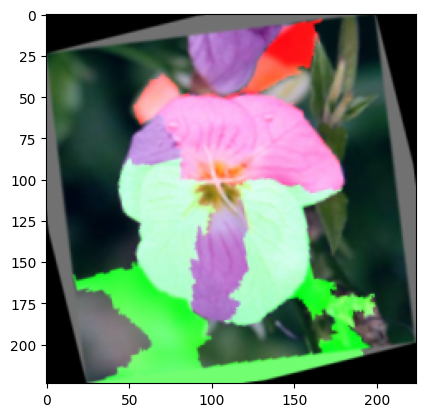

In [16]:
y = skimage.transform.rotate(y, 360-173)
plt.imshow(y)

(224, 224, 3)


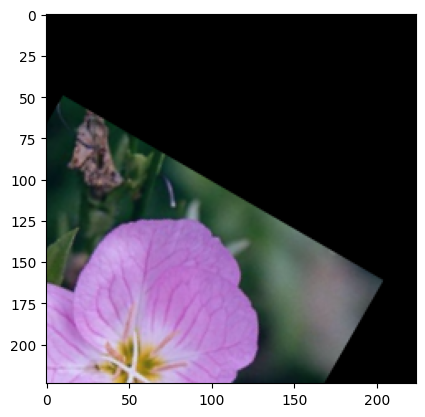

In [ ]:
tform = skimage.transform.EuclideanTransform(translation=(10,50), rotation=np.pi/6)
float_img = skimage.img_as_float(img)
tmp = skimage.transform.warp(float_img, tform.inverse, mode="constant", cval=0)
print(tmp.shape)
plt.imshow(tmp)

(224, 224, 3)


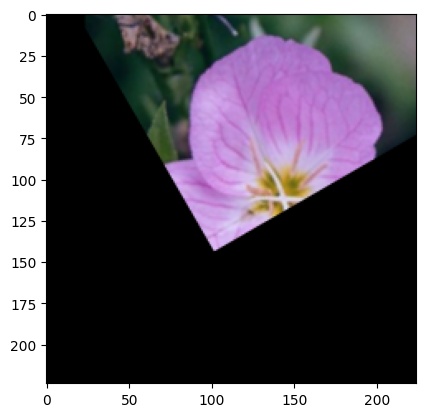

In [ ]:
tform = skimage.transform.EuclideanTransform(translation=(-10,-50), rotation=-np.pi/6)
float_img = skimage.img_as_float(tmp)
tmp = skimage.transform.warp(float_img, tform.inverse, mode="constant", cval=0)
print(tmp.shape)
plt.imshow(tmp)

Reference: https://scikit-image.org/docs/stable/auto_examples/transform/plot_transform_types.html#sphx-glr-auto-examples-transform-plot-transform-types-py